In [1]:
from pylab import *
from scipy import *
from matplotlib.colors import LogNorm
from matplotlib import colors
from IPython.display import Image
from scipy.integrate import quad
from scipy import interpolate
from scipy.special import jn, gamma
from scipy.misc import derivative
from scipy.integrate import nquad
import camb
from camb import model, initialpower
import matplotlib.patches as patches
#import WLanalysis

In [29]:
#############################################################
############ constants and cosmology functions ##############
#############################################################

c = 299792.458 #km/s
Gnewton = 6.674e-8 #cgs cm^3/g/s^2

#### cosmology WMAP9
h = 0.7
H0 = h*100
oc = 0.236
ob = 0.046
om = ob+oc
ol = 1-om #0.718
ns = 0.9646
s8 = 0.817

#### IA related constants
C1rhoc = 0.0134 #C1*rho_crit
bD = 1.77 #LOWZ measurement
Ai=5.2
const = bD*C1rhoc*om/2.0/pi**2

#### small functions
H = lambda z: H0*sqrt(om*(1+z)**3+ol)
H_inv = lambda z:  1/(H0*sqrt(om*(1+z)**3+ol))
Hcgs = lambda z: H(z)*3.24e-20
DC = lambda z: c*quad(H_inv, 0, z)[0]
W_fcn = lambda z: (pz(z) / DC(z))**2 / c * H(z) # dchi/dz = c/H
rho_cz = lambda z: 0.375*Hcgs(z)**2/pi/Gnewton

#### growth D(a)
zarr1=linspace(0,1,501)
az = lambda z: 1.0/(1.0+z)
za = lambda a: 1.0/a-1
D_fcn = lambda a: H(za(a))/H0 * quad(lambda a: (om/a+ol*a**2)**(-1.5), 0, a)[0]
D1 = D_fcn(1)
D_arr = array([D_fcn (az(iz)) for iz in zarr1])/D1

#### redshift kernel
zmin,zmax = 0.16, 0.36
zcenter,dndz = load('lowz/dndz_lowz.npy')
pz = interpolate.interp1d(zcenter,dndz,bounds_error=0,fill_value=0.)

Wnorm = quad(W_fcn, zmin, zmax) [0]
W_arr = array([W_fcn(iz)/Wnorm for iz in zarr1])
W = interpolate.interp1d(zarr1,W_arr,bounds_error=0,fill_value=0.)

#### logrithmic growth f=dln(D)/dln(a), 
#### first do dD/da then x a/D
dnda_arr = array([derivative(D_fcn, az(iz), dx=1e-5) for iz in zarr1])
f_arr = az(zarr1)/D_arr * dnda_arr

Dinterp = interpolate.interp1d(zarr1,D_arr,bounds_error=0,fill_value=0.)
finterp = interpolate.interp1d(zarr1,f_arr,bounds_error=0,fill_value=0.)
betaD = lambda z: finterp(z)/bD

/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in divide


In [3]:
###################################
############ load data ############
###################################

data_mean = loadtxt('lowz/fulle_bins2D_cross_final.dat')[:,5].reshape(25,-1).T
rp_bins = loadtxt('lowz/fulle_bins2D_cross_final.dat')[:,0].reshape(25,-1).T
pi_bins = loadtxt('lowz/fulle_bins2D_cross_final.dat')[:,1].reshape(25,-1).T

#### for plotting purpose, make a reflection for negative r
data_mean2=concatenate([data_mean,data_mean])
rp_bins2=concatenate([rp_bins,-rp_bins])
pi_bins2=concatenate([pi_bins,pi_bins])

icolors=['yellow','cyan','red','blue','mediumpurple']
icolors_deep=['darkorange','deepskyblue','maroon','midnightblue','purple']
bounds=logspace(-3,0,6)

In [4]:
################################################
#### get matter power spectrum from camb #######
################################################

Nz = 21
zarr = linspace(zmin, zmax, Nz) ### for camb z bins

#### takes some time to compute
pars = camb.CAMBparams()
pars.set_cosmology(H0=70, ombh2=ob*h**2, omch2=om*h**2) #omch2=oc*h**2)
pars.InitPower.set_params(ns=0.965)
pars.set_matter_power(redshifts=zarr, kmax=100.0)
results = camb.get_results(pars)
#pars.NonLinear = model.NonLinear_none  #linear

#### get nonlinear power spectrum ########
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=100.0, npoints = 150)

Note: redshifts have been re-sorted (earliest first)


In [35]:
########################################################
### computing theoretical 2D correlation, SM16 eq 12. ##
#### see google doc notes for the FFTLog method ########
########################################################

#### prepare the frequencies at different redshifts
Nk = len(kh_nonlin)
klogstep = log(kh_nonlin[1]/kh_nonlin[0])
kmin, kmax = kh_nonlin[[0,-1]]
ifreq = fftfreq(Nk)
nu = 1j*2*pi*fftfreq(Nk, d=klogstep) ## the argument goes into k^nu_n, now nu_n is nu_arr

#### get coefficients C_n of FFT(kPk)=Simga C_n k^nu
def cn_fun (i):#i is the redshift counter
    kPk = pk_nonlin[i]*kh_nonlin
    kPk_fft = fft(kPk) ## FFT
    cn = kPk_fft*kmin**(-nu) 
    return cn
cn_arr = array(map(cn_fun, arange(Nz))).reshape(21,1,1,150)
# print cn_arr.shape, rp_bins2.shape, pi_bins2.shape

########## compute xi(pi, rp) ################
#### below one line is to test without the RSD term
#### Fcoeff = lambda rp, PI, nu: rp**2/(rp**2+PI**2)**(2.0+nu/2.0)*cos(pi*nu/2.0)*gamma(3.0+nu)/(1-nu**2)

#### full term includes RSD
Nr = 201
rpmax = 100

betaD_arr = [betaD(iz) for iz in z_nonlin] 
rppitheo = linspace(0,rpmax,Nr)
rptheo, pitheo = meshgrid(rppitheo, rppitheo)
idz = zarr[1]-zarr[2]
Fcoeff = lambda rp, PI, betaD: rp**2/(rp**2+PI**2)**(3.0+nu/2.0)*cos(pi*nu/2.0)*gamma(3.0+nu)*( (nu-3.0)*(rp**2+PI**2)+ (rp**2-(3+nu)*PI**2*betaD))/(nu-3.0)/(nu**2-1)
xi_int = lambda i: sum(W(zarr[i])/Dinterp(zarr[i])*cn_arr[i]
                       *Fcoeff(rptheo.reshape(Nr,Nr,1), pitheo.reshape(Nr,Nr,1), 
                       betaD_arr[i]), axis=-1)/Nk*idz

#### integrate over the redshift kernel ##########

#### note const is for de vaucouleurs shape measurement method (used in SM16 fig.10)
#### isophotal shapes give you 40% higher Ai than re-Gaussian shapes (re-Gaussian gives Ai=4.6)
xi_all = const*sum(array(map(xi_int, range(Nz))), axis=0)

#### mirror the outputs, so we can plot it nicely like SM16 Fig.10
xi_all4 = zeros((Nr*2, Nr*2))
xi1 = real(xi_all)
xi_all4[:Nr, :Nr] = xi1[::-1,::-1]
xi_all4[Nr:, :Nr] = xi1[:,::-1]
xi_all4[:Nr, Nr:] = xi1[::-1,:]
xi_all4[Nr:, Nr:] = xi1
rp4, pi4 = meshgrid(linspace(-rpmax,rpmax,2*Nr), linspace(-rpmax,rpmax,2*Nr))

/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in power
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in divide


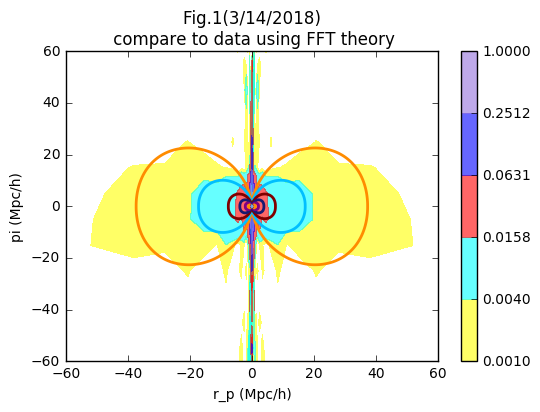

In [37]:
###########################################
#### reproduce SM16 Fig.10 ################
###########################################

f, ax=subplots(1,1, figsize=(6,4))
CS=ax.contourf(rp_bins2, pi_bins2, data_mean2, bounds,colors=icolors,alpha=0.6)
ax.set_ylim(-60,60)
CS2=ax.contour(rp4, pi4, Ai*xi_all4, bounds,colors=icolors_deep,linewidths=2,alpha=1)
cbar = plt.colorbar(CS)
ax.set_xlim(-60,60)
ax.set_xlabel('r_p (Mpc/h)')
ax.set_ylabel('pi (Mpc/h)')
ax.set_title('Fig.1(3/14/2018)\n compare to data using FFT theory')
show()

######## plot with more bins ###################
# bounds2 = logspace(-3,0,11)
# seed(24)
# ic2=rand(15,3)
# f, ax=subplots(1,1, figsize=(6,4))
# CS=ax.contourf(rp_bins2, pi_bins2, data_mean2, bounds2,colors=ic2,alpha=0.6)
# ax.set_ylim(-60,60)
# CS2=ax.contour(rp4, pi4, Ai*xi_all4, bounds2,colors=ic2,linewidths=2,alpha=1)
# cbar = plt.colorbar(CS)
# ax.set_xlim(-60,60)
# ax.set_xlabel('r_p (Mpc/h)')
# ax.set_ylabel('pi (Mpc/h)')
# ax.set_title('Fig.2(3/14/2018) more bins')
# show()

In [40]:
#####################################################
########### constraints on A_IA with data ###########
#####################################################

#### get error bar from lowz jacknife
data_jk = array([loadtxt('lowz/fulle_bins2D_cross_jk%i_final.dat'%i)[:,5].reshape(25,-1).T for i in range(100)])
#print data_jk.shape, rp_bins.shape, pi_bins.shape

#### calculate theory value at each (pi, rp) bin as the lowz data
xi_int_lowzbin = lambda i: sum(W(zarr[i])/Dinterp(zarr[i])*cn_arr[i]
                 *Fcoeff(rp_bins.reshape(-1,1), pi_bins.reshape(-1,1), betaD_arr[i]), axis=-1)/Nk*idz
xi_lowzbin = const*sum(array(map(xi_int_lowzbin, range(Nz))), axis=0)
xi_lowzbin = real(xi_lowzbin.flatten())
#print xi_lowzbin.shape, rp_bins2.shape, pi_bins2.shape


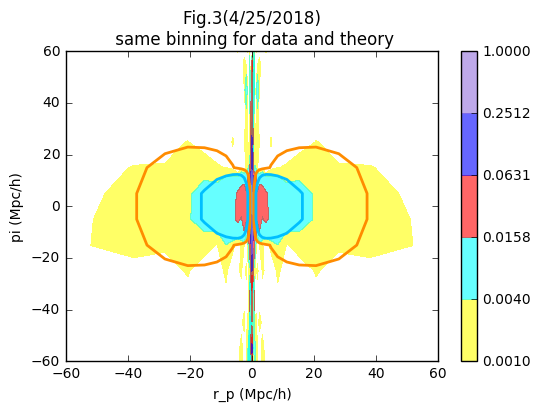

In [39]:
##############################################
######## plot out just to make sure ##########
##############################################

#### mirror the output for plotting 
xi_lowzbin2 = concatenate([xi_lowzbin.reshape(20,-1),xi_lowzbin.reshape(20,-1)])

f, ax=subplots(1,1, figsize=(6,4))
CS=ax.contourf(rp_bins2, pi_bins2, data_mean2, bounds,colors=icolors,alpha=0.6)
ax.set_ylim(-60,60)
CS2=ax.contour(rp_bins2, pi_bins2, Ai*xi_lowzbin2, bounds,colors=icolors_deep,linewidths=2,alpha=1)
cbar = plt.colorbar(CS)
ax.set_xlim(-60,60)
ax.set_xlabel('r_p (Mpc/h)')
ax.set_ylabel('pi (Mpc/h)')
ax.set_title('Fig.3(4/25/2018)\n same binning for data and theory')
show()

In [42]:
#######################################
######### test 1D fit #################
#######################################

#### set up binning
pi1d = sort(unique(pi_bins)) ## bin centers
dpi = pi1d[1]-pi1d[0] ## bin size
rp1d = unique(rp_bins)

#### integrate over the pi direction to get 1D correlation
data_1d = sum(data_mean, axis=0)*dpi
theo_1d = sum(xi_lowzbin.reshape(20,-1), axis=0)*dpi

#### this is just to plot out theory in denser bins, not used for fitting
dpi_dense = rppitheo[1]-rppitheo[0]
theo_1d_dense = sum(xi_all4, axis=0)[Nr:]*dpi_dense

#### error bar from Jackknife
jk_1d = sum(data_jk, axis=1)*dpi

#print data_mean.shape, rp1d.shape, data_1d.shape, theo_1d.shape, jk_1d.shape, dpi
#print theo_1d_dense.shape, rppitheo.shape, dpi_dense

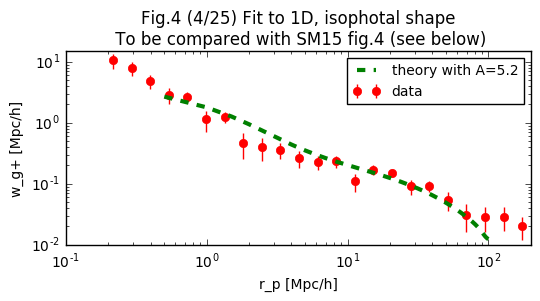

In [44]:
#######################################
########## plot out 1D fit ############
#######################################

########## here I used A_IA=5.2, the amplitude obtained in the paper
f, ax = subplots(1,1,figsize=(6,2.5))
ax.errorbar(rp1d, data_1d, sqrt(99.)*std(jk_1d,axis=0), fmt='o',color='r',mec='r',label='data',capsize=0, capthick=5)
ax.plot(rppitheo, Ai*theo_1d_dense,'g--', label='theory with A=%.1f'%(Ai), lw=3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('r_p [Mpc/h]')
ax.set_ylabel('w_g+ [Mpc/h]')
ax.set_xlim(1e-1, 200)
ax.set_ylim(1e-2, 15)
ax.legend(frameon=1, fontsize=10, loc=0)
ax.set_title('Fig.4 (4/25) Fit to 1D, isophotal shape\n To be compared with SM15 fig.4 (see below)')
show()

In [45]:
############## Fig.4 from SMM15, which I tried to reproduce ##########
Image(url= "fig4.jpg")

In [50]:
#########################################
########### do my own 1d fitting ########
#########################################

###### limit to range rp=[6, 65], since we don't know how to model the FOG region
idxcut = where((rp1d<65)&(rp1d>6))[0]
Np = len(idxcut)-1
rp1dcut = rp1d[idxcut]
data1dcut = data_1d[idxcut]
theocut = interpolate.interp1d(rppitheo, theo_1d_dense)(rp1dcut)

###### get covariance
jk1dcut = jk_1d[:,idxcut]
cov1d = 99.0*cov(jk1dcut,rowvar=0)
cov1dI = mat(cov1d).I
## print jk1dcut.shape, cov1d.shape

##### 1d function to fit A_IA (called Ai below), from model to data
def chisq1d (Ai):
    dN = mat(Ai*theocut-data1dcut)
    return float(dN*cov1dI*dN.T)/Np

##### we don't need anything fancy, can just do a bruth force search using an array of A_IA
Ai_arr = linspace(1, 10, 201)
chisq1darr = [chisq1d(iAi) for iAi in Ai_arr]
##### and take the A_IA with lowest chi^2 value to get the best fit Abest 
Abest = Ai_arr[argmin(chisq1darr)]

In [51]:
###########################################
################# now try my 2d fitting ###
###########################################

###### limit to range rp=[6, 65]
idx2dcut = where((rp_bins<65)&(rp_bins>6) & (abs(pi_bins)<40))
data2dcut = data_mean[idx2dcut]
theo2dcut = xi_lowzbin.reshape(20,-1)[idx2dcut]

###### get covariance
jk2dcut = array([idatajk[idx2dcut] for idatajk in data_jk])
cov2d = 99.0*cov(jk2dcut,rowvar=0)
cov2dI = mat(cov2d).I
Np2d = len(cov2d)-1

##### 2d function to fit A_IA, from model to data
def chisq2d (Ai):
    dN = mat(Ai*theo2dcut-data2dcut)
    return float(dN*cov2dI*dN.T)/Np2d

chisq2darr = [chisq2d(iAi) for iAi in Ai_arr]
Abest2d = Ai_arr[argmin(chisq2darr)]

#print idx2dcut[0].shape, rp_bins.shape, xi_lowzbin.reshape(20,-1).shape, data_mean.shape, data_jk.shape
#print data2dcut.shape, theo2dcut.shape, jk2dcut.shape, Np2d

In [55]:
########################################################
###### here are bunch of sanity checks for 2d fitting ##
########################################################

################ (1) 2d fit, with only diagnal term in covariance
cov2dI_diag = mat(cov2d*identity(len(cov2d))).I
def chisq2d_diag (Ai):
    dN = mat(Ai*theo2dcut-data2dcut)
    return float(dN*cov2dI_diag*dN.T)/Np2d

chisq2darr_diag = [chisq2d_diag(iAi) for iAi in Ai_arr]
Abest2d_diag = Ai_arr[argmin(chisq2darr_diag)]

############## (2) 2d fit, fold +/- Pi direction to reduce the number of bins by half
idx2dcut = where((rp_bins<65)&(rp_bins>6) & (abs(pi_bins)<40))
data2dcut = data_mean[idx2dcut]
theo2dcut = xi_lowzbin.reshape(20,-1)[idx2dcut]
jk2dcut = array([idatajk[idx2dcut] for idatajk in data_jk])

fold_pi = lambda data: 0.5*(data.reshape(8,8)[4:,:][::-1] + data.reshape(8,8)[:4,:]).flatten()
data2dfold, theo2dfold = [fold_pi(idata) for idata in [data2dcut,theo2dcut]]
jk2dfold = array([fold_pi(ijk2d) for ijk2d in jk2dcut]).reshape(100,-1)

cov2dfold = 99.0*cov(jk2dfold,rowvar=0)
cov2dIfold = mat(cov2dfold).I
Np2dfold = len(cov2dfold)-1

def chisq2dfold (Ai):
    dN = mat(Ai*theo2dfold-data2dfold)
    return float(dN*cov2dIfold*dN.T)/Np2dfold

chisq2darrfold = [chisq2dfold(iAi) for iAi in Ai_arr]
Abest2dfold = Ai_arr[argmin(chisq2darrfold)]

#############
print 'Abest=%.1f, Abest2d=%.1f, Abest2d_diag=%.1f, Abest2dfold=%.1f'%(Abest, Abest2d, Abest2d_diag, Abest2dfold)
# print idx2dcut[0].shape, rp_bins.shape, xi_lowzbin.reshape(20,-1).shape, data_mean.shape, data_jk.shape
# print data2dcut.shape, theo2dcut.shape, jk2dcut.shape, Np2d
# array(chisq2darr_diag)-array(chisq2darr)

Abest=5.0, Abest2d=6.4, Abest2d_diag=6.1, Abest2dfold=5.9


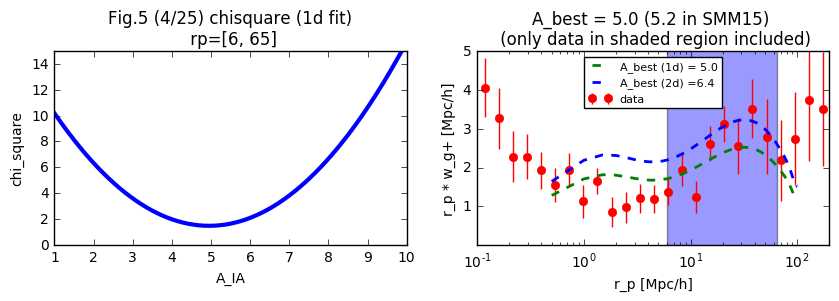

In [59]:
##########################################################
### plot my 1D fit results ############################### 
##########################################################

### I found A_IA = 5.0, compared to 5.2 in the paper #####
f, (ax2, ax) = subplots(1,2,figsize=(10,2.5))
ax.errorbar(rp1d, rp1d*data_1d, sqrt(99.)*rp1d*std(jk_1d,axis=0), fmt='o',color='r',mec='r',label='data',capsize=0, capthick=5)
ax.plot(rppitheo, rppitheo*theo_1d_dense*Abest,'g--', label='A_best (1d) = %.1f'%(Abest), lw=2)
ax.plot(rppitheo, rppitheo*theo_1d_dense*Abest2d,'b--',lw=2, label='A_best (2d) =%.1f'%(Abest2d))
ax.set_xscale('log')
ax.set_xlabel('r_p [Mpc/h]')
ax.set_ylabel('r_p * w_g+ [Mpc/h]')
ax.set_xlim(1e-1, 200)
ax.set_ylim(1e-2, 5)
ax.legend(frameon=1, fontsize=8, loc=0)
ax.set_title('A_best = %.1f (5.2 in SMM15) \n (only data in shaded region included)'%(Abest))
ax.add_patch(patches.Rectangle(
        (6, 1e-2),   # (x,y)
        65-6,          # width
        20,          # height
        alpha=0.4))

ax2.plot(Ai_arr, chisq1darr, lw=3)
ax2.set_xlabel('A_IA')
ax2.set_ylabel('chi_square')
ax2.set_title('Fig.5 (4/25) chisquare (1d fit)\n rp=[6, 65]')
ax2.set_ylim(0,15)
show()

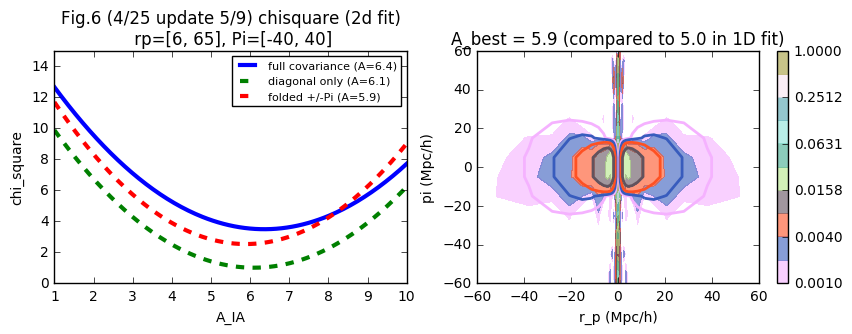

In [61]:
##########################################################
### plot my 2D fit results ############################### 
##########################################################

f, (ax2, ax) = subplots(1,2,figsize=(10,3))

CS=ax.contourf(rp_bins2, pi_bins2, data_mean2, bounds2,colors=ic2,alpha=0.6)
ax.set_ylim(-60,60)
CS2=ax.contour(rp_bins2, pi_bins2, xi_lowzbin2*Abest2dfold, bounds2,colors=ic2,linewidths=2,alpha=1)
cbar = plt.colorbar(CS)
ax.set_xlim(-60,60)
ax.set_xlabel('r_p (Mpc/h)')
ax.set_ylabel('pi (Mpc/h)')
ax.set_title('A_best = %.1f \n (compared to 5.0 in 1D fit)'%(Abest2dfold))

ax2.plot(Ai_arr, chisq2darr, 'b-',lw=3, label='full covariance (A=%.1f)'%(Abest2d))
ax2.plot(Ai_arr, chisq2darr_diag, 'g--',lw=3, label='diagonal only (A=%.1f)'%(Abest2d_diag))
ax2.plot(Ai_arr, chisq2darrfold, 'r--',lw=3, label='folded +/-Pi (A=%.1f)'%(Abest2dfold))
ax2.set_xlabel('A_IA')
ax2.set_ylabel('chi_square')
ax2.set_ylim(0, 15)
ax2.set_title('Fig.6 (4/25 update 5/9) chisquare (2d fit)\n rp=[6, 65], Pi=[-40, 40]')
ax2.legend(frameon=1, fontsize=8, loc=0)
show()

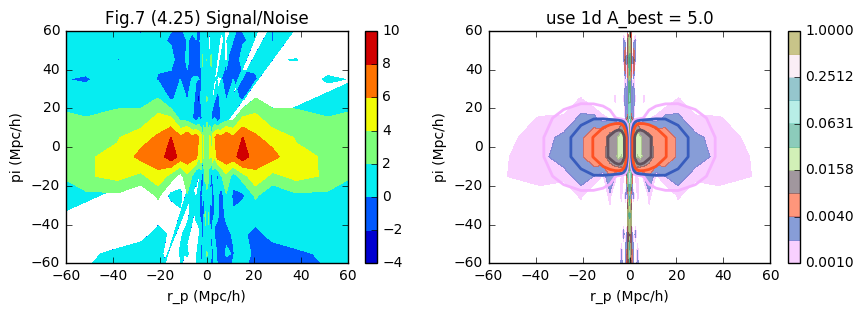

In [21]:
################ plot it out just to make sure
jk2dstd = std(data_jk, axis=0)
jk2dstd2 = sqrt(99)*concatenate([jk2dstd,jk2dstd])

f, (ax2, ax) = subplots(1,2,figsize=(10,3))

CS2=ax2.contourf(rp_bins2, pi_bins2, data_mean2/jk2dstd2)
ax2.set_ylim(-60,60)
#cbar = plt.colorbar(CS)
f.colorbar(CS2, ax=ax2)
ax2.set_xlim(-60,60)
ax2.set_xlabel('r_p (Mpc/h)')
ax2.set_ylabel('pi (Mpc/h)')
ax2.set_title('Fig.7 (4.25) Signal/Noise')

CS=ax.contourf(rp_bins2, pi_bins2, data_mean2, bounds2,colors=ic2,alpha=0.6)
ax.set_ylim(-60,60)
CSb=ax.contour(rp_bins2, pi_bins2, xi_lowzbin2*Abest, bounds2,colors=ic2,linewidths=2,alpha=1)
#cbar = plt.colorbar(CS)
f.colorbar(CS, ax=ax)
ax.set_xlim(-60,60)
ax.set_xlabel('r_p (Mpc/h)')
ax.set_ylabel('pi (Mpc/h)')
ax.set_title('use 1d A_best = %.1f'%(Abest))

show()

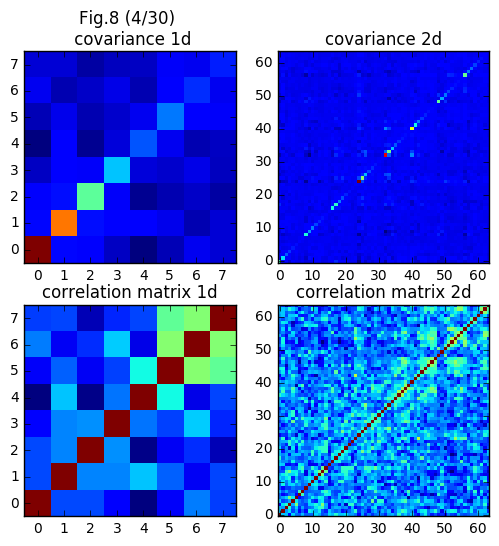

In [22]:
f, axes = subplots(2,2,figsize=(6,6))
axes[0][0].imshow(cov1d,origin='lower',interpolation='nearest')
axes[0][0].set_title('Fig.8 (4/30) \n covariance 1d')
axes[1][0].imshow(WLanalysis.corr_mat(cov1d),origin='lower',interpolation='nearest')
axes[1][0].set_title('correlation matrix 1d')


axes[0][1].imshow(cov2d,origin='lower',interpolation='nearest')
axes[0][1].set_title('covariance 2d')
axes[1][1].imshow(WLanalysis.corr_mat(cov2d),origin='lower',interpolation='nearest')
axes[1][1].set_title('correlation matrix 2d')

show()

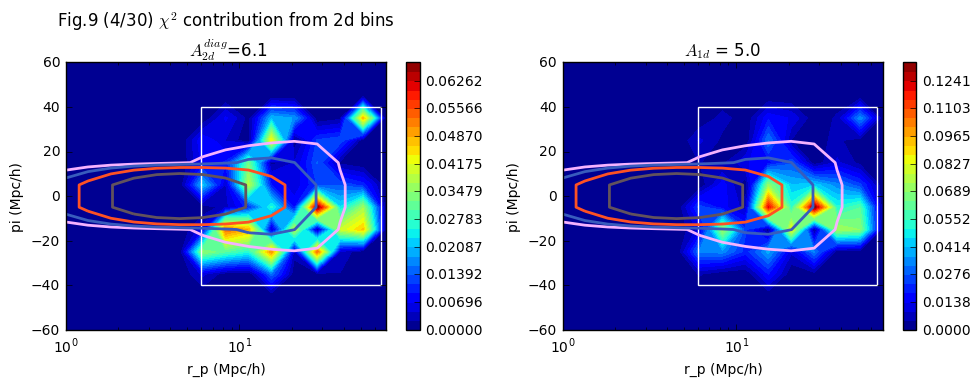

In [23]:
### investigate which bins contribute most to the chisq
################ plot it out just to make sure

# def chisq2d_diag (Ai):
#     dN = mat(Ai*theo2dcut-data2dcut)
#     return float(dN*cov2dI_diag*dN.T)/Np2d

ichisq_diag_best = (Abest2d_diag*theo2dcut-data2dcut)**2/diag(cov2d)/Np2d
#print dNbest
#print idx2dcut
chisq2d_contrib = zeros(shape=rp_bins.shape)
chisq2d_contrib[idx2dcut]=ichisq_diag_best

ichisq_diag_Abest = (Abest*theo2dcut-data2dcut)**2/diag(cov2d)/Np2d
#print dNbest
#print idx2dcut
chisq2d_contrib_Abest = zeros(shape=rp_bins.shape)
chisq2d_contrib_Abest[idx2dcut]=ichisq_diag_Abest

f, (ax0, ax) = subplots(1,2,figsize=(10,4))
bounds_chisq = linspace(amin(chisq2d_contrib),amax(chisq2d_contrib), 30)
CS0=ax0.contourf(rp_bins, pi_bins, chisq2d_contrib, bounds_chisq)
cbar = plt.colorbar(CS0, ax=ax0)
# ax0.imshow(chisq2d_contrib,origin='lower', 
#            extent=[amax(rp_bins), amin(rp_bins), amin(pi_bins), amax(pi_bins)],aspect='auto',
#           interpolation='nearest')
ax0.contour(rp_bins2, pi_bins2, xi_lowzbin2*Abest2d_diag, bounds2,colors=ic2,linewidths=2,alpha=1)
ax0.set_ylim(-60,60)
ax0.set_xlim(1,70)
ax0.add_patch(
    patches.Rectangle(
        (6, -40),
        65-6,
        80,
        edgecolor='w',
        fill=False      # remove background
    ))
ax0.set_title('Fig.9 (4/30) $\chi^2$ contribution from 2d bins \n $A_{2d}^{diag}$=%.1f'%(Abest2d_diag))    
ax0.set_xlabel('r_p (Mpc/h)')
ax0.set_ylabel('pi (Mpc/h)')
ax0.set_xscale('log')

# CS=ax.contourf(rp_bins, pi_bins, data_mean, bounds2,colors=ic2,alpha=0.6)
# ax.set_ylim(-60,60)
# CS2=ax.contour(rp_bins2, pi_bins2, xi_lowzbin2*Abest2d_diag, bounds2,colors=ic2,linewidths=2,alpha=1)
# cbar = plt.colorbar(CS,ax=ax)

bounds_chisq_Abest = linspace(amin(chisq2d_contrib_Abest),amax(chisq2d_contrib_Abest), 30)
CS=ax.contourf(rp_bins, pi_bins, chisq2d_contrib_Abest, bounds_chisq_Abest)
cbar2 = plt.colorbar(CS, ax=ax)
ax.contour(rp_bins2, pi_bins2, xi_lowzbin2*Abest2d_diag, bounds2,colors=ic2,linewidths=2,alpha=1)
ax.set_ylim(-60,60)
ax.set_xlim(1,70)
ax.add_patch(
    patches.Rectangle(
        (6, -40),
        65-6,
        80,
        edgecolor='w',
        fill=False      # remove background
    ))
ax.set_title('$A_{1d}$ = %.1f'%(Abest))    
ax.set_xlabel('r_p (Mpc/h)')
ax.set_ylabel('pi (Mpc/h)')
ax.set_xscale('log')

ax.set_xscale('log')
plt.tight_layout()
show()

In [24]:
dN1d = Abest*theocut-data1dcut
ichisq1d_contrib  =dN1d**2/diag(cov1d)/Np
#print ichisq1d_contrib

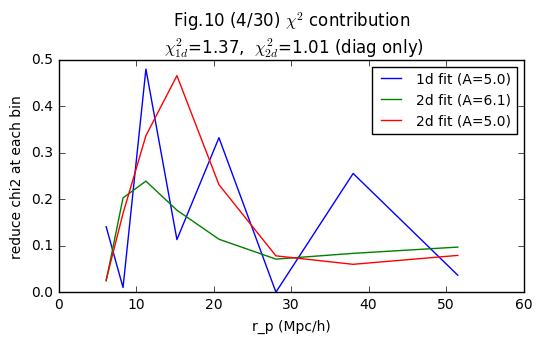

In [25]:
f, ax=subplots(1,1,figsize=(6,3))
ax.plot(rp1dcut, ichisq1d_contrib, label='1d fit (A=%.1f)'%(Abest))
ax.plot(rp1dcut, sum(chisq2d_contrib[idx2dcut].reshape(8,8),axis=1), label='2d fit (A=%.1f)'%(Abest2d_diag))
ax.plot(rp1dcut, sum(chisq2d_contrib_Abest[idx2dcut].reshape(8,8),axis=1), label='2d fit (A=%.1f)'%(Abest))
ax.set_xlabel('r_p (Mpc/h)')
ax.set_ylabel('reduce chi2 at each bin')
ax.legend(loc=0,frameon=1, fontsize=10)
ax.set_title('Fig.10 (4/30) $\chi^2$ contribution\n $\chi^2_{1d}$=%.2f,  $\chi^2_{2d}$=%.2f (diag only)'%(sum(ichisq1d_contrib), sum(chisq2d_contrib[idx2dcut])))
show()

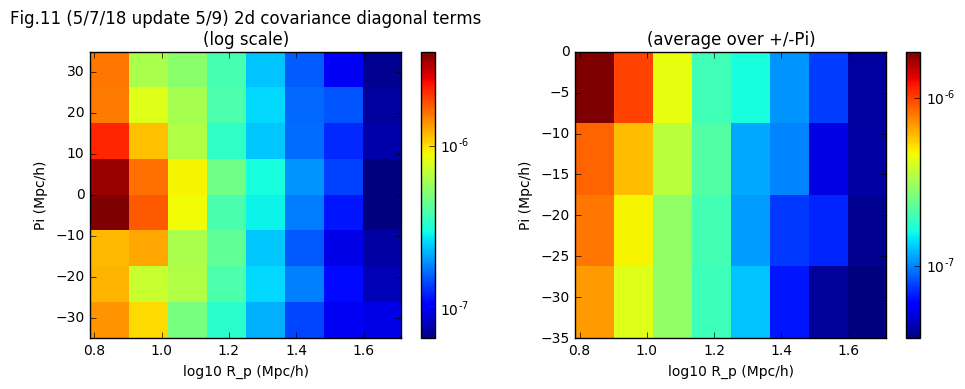

In [26]:
f, (ax,ax3)=subplots(1,2,figsize=(10,4))
cb=ax.imshow(diag(cov2d).reshape(8,8),interpolation='nearest',origin='lower',
         extent=(log10(amin(rp_bins[idx2dcut])), log10(amax(rp_bins[idx2dcut])), 
                amin(pi_bins[idx2dcut]), amax(pi_bins[idx2dcut])),aspect='auto'
             ,norm=mpl.colors.LogNorm())
ax.set_xlabel('log10 R_p (Mpc/h)')
ax.set_ylabel('Pi (Mpc/h)')
colorbar(cb,ax=ax)
ax.set_title('Fig.11 (5/7/18 update 5/9) 2d covariance diagonal terms\n(log scale)')

# cb2=ax2.imshow(diag(cov2d).reshape(8,8),interpolation='nearest',origin='lower',
#          extent=(log10(amin(rp_bins[idx2dcut])), log10(amax(rp_bins[idx2dcut])),
#                 amin(pi_bins[idx2dcut]), amax(pi_bins[idx2dcut])),aspect='auto')
# ax2.set_xlabel('log10 R_p (Mpc/h)')
# ax2.set_ylabel('Pi (Mpc/h)')
# colorbar(cb2,ax=ax2)
# ax2.set_title('(linear scale)')

cb3=ax3.imshow(diag(cov2dfold).reshape(4,8),interpolation='nearest',origin='lower',
         extent=(log10(amin(rp_bins[idx2dcut])), log10(amax(rp_bins[idx2dcut])),
                amin(pi_bins[idx2dcut]),0),aspect='auto',norm=mpl.colors.LogNorm())
ax3.set_xlabel('log10 R_p (Mpc/h)')
ax3.set_ylabel('Pi (Mpc/h)')
colorbar(cb3,ax=ax3)
ax3.set_title('(average over +/-Pi)')

plt.tight_layout()
show()

In [27]:
chimod = chisq2darr[argmin(chisq2darr)],chisq2darrfold[argmin(chisq2darrfold)], chisq2darr_diag[argmin(chisq2darr_diag)],chisq1darr[argmin(chisq1darr)]
chinull =  chisq2d(0), chisq2dfold(0), chisq2d_diag(0), chisq1d(0)
chifull = [sqrt(chinull[i]-chimod[i]) for i in range(4)]
#SNR = sqrt(chi2_null-chi2_model)
print 'chi2_model 2d:%.2f  2d(fold):%.2f  2d(diag):%.2f  1d:%.2f'%chimod
print 'chi2_null  2d:%.2f  2d(fold):%.2f  2d(diag):%.2f  1d:%.2f'%chinull
print 'SNR        2d:%.2f  2d(fold):%.2f  2d(diag):%.2f  1d:%.2f'%(chifull[0],chifull[1],chifull[2],chifull[3])

chi2_model 2d:3.49  2d(fold):2.54  2d(diag):1.01  1d:1.47
chi2_null  2d:16.40  2d(fold):15.82  2d(diag):13.71  1d:15.17
SNR        2d:3.59  2d(fold):3.65  2d(diag):3.56  1d:3.70
